In [53]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
import datetime
import pyLDAvis
import pyLDAvis.sklearn
import warnings
import spacy
from   sklearn.model_selection import cross_val_score, train_test_split
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.model_selection import GridSearchCV

# Final Project
#### Table of Contents
0. Project Team
1. Introduction and Hypothesis <br>
        I. Introduction<br>
        II. Research Question<br>
        III. Hypothesis<br>
        IV. Expectations
2. Data and Methods (**[link to dataset/csv file](https://drive.google.com/file/d/1WLinKhi9Qkt_x6s2hRwbEurnAYemfgk8/view?usp=sharing)**)<br>
        I. Overview of Methods and Tasks<br>
        II. Corpus Creation<br>
        III. Metadata + Dataset Information<br>
        IV. Exploratory Data Analysis<br>
        V. LDA Topic Modeling (Doc-Topic Matrix) + Classification<br>
        VI. Word Embedding Matrix + Classification<br>
        VII. Word Counts (Bag of Words) Matrix + Classification
3. Results
4. Conclusion and Discussion
5. Resources Consulted

## 0. Project Team

Estelle Hooper (ehh52) and Gabriella Chu (gc386)

## 1. Introduction and Hypothesis

### I. Introduction
During the week of January 1, 2000, the number one song on the [Billboard Hot 100 chart](https://www.billboard.com/charts/hot-100/2000-01-01/) was "Smooth" by Santana Featuring Rob Thomas. According to Genius lyrics(https://genius.com/2953666), "'Smooth' is a pinnacle of the tail end of the rock era, and a perfect example of a smooth transition from the classic rock sound (Santana) to modern adult contemporary music (Thomas).' In the lyrics, Santana and Thomas sing to a love interest (presumably a woman).
>My muñequita, my Spanish Harlem Mona Lisa<br>
You're my reason for reason, the step in my groove

>I would give my world to lift you up<br>
I could change my life to better suit your mood<br>
Because you're so smooth

When comparing "Smooth" to [today's (May 19, 2022)](https://www.billboard.com/charts/hot-100/) number one song on the Billboard Hot 100, ["First Class" by Jack Harlow](https://genius.com/Jack-harlow-first-class-lyrics), the lyrics are on the same theme of romance, yet treated in a different way.

>I been a (G), throw up the (L), s*x in the (A.M.), uh-huh
(O-R-O-U-S, yeah) <br>
And I can put you in (First class, up in the sky), mm, mm
I can put you in (First class)

With a little over a 20 year difference, it is common knowledge that the most popular genre/sound of music will evolve over time with different instruments and technology. In this case, it's Santana's classic rock to Jack Harlow's hip-hop. However, lyrical themes tend to remain, such as love or youth. Given how many and how often songs rise in popularity, as evidenced by the existence of Billboard's Hot 100 chart (since 1958!) that updates weekly, we find that computational methods would be ideal to analyze the large sum of these popular songs that rise in the music market and analyze the changes and nuances in these topics over time. For example, both "Smooth" and "First Class" are number one hits of their time addressing a love interest, yet the former uses more chivalrous lyrics and the latter more sexual and playful.


### II. Research Question
#### What lyrical inspirations define the music industry every decade, and how has their treatment changed over time?
By analyzing the most popular songs of 1960-2021 according to the Billboard Hot 100 charts and their lyrics, we hope to discover distinct topics in all these songs. We want to know the life cycle of these topics, such as if they endured across decades, fell or rose in popularity, or were only popular for a certain decade. <br>

In short, to answer our research question, we will use topic modeling on the most popular songs from 1960 to 2021 and visualize them using time-series plots and scatterplots. Then, we will verify these topics' distinctiveness to each decade or year in two avenues. First, we'll read samples of the songs assigned to these topics and their metadata (date on chart, weeks on chart, etc.). Second, we will predict year or decade using the matrix containing these topic-modeling distributions.


### III. Hypothesis 
As hinted in the introduction, we expect to see a topic like love be an enduring theme across all decades, but we believe that the LDA topic modeling will distinguish lyrics about physical attraction and flowery, romantic lyrics (therefore, creating multiple topics about romance). We also expect to see some topics whose top words include niche words specific to a genre that was popular during the time. For example, R&B and rap (particularly, African-American artists) rose in the 1990-2000, meaning that topics with AAVE (African American Vernacular English) could arise as a proxy for those genres.

### IV. Expectations
The foundation of our research project is dependent on topic modeling, and if we will be able to find meaningful and distinguishable topics in the song data. Overall, we don't expect to have many different topics given the size of our corpus and span of time it covers. We only expect very common themes to arise as a topic (such as love or youth), but other lyrical topics in music to be lost. For example, many artists are lyrically inspired by politics, but it will be difficult for the topic modeling to pick up a broad topic of "current events" because the names of politicians and news events are all very specifc, and the model does not have the domain knowledge to lump them all together.

## 2. Data and methods

### I. Overview of Methods and Tasks

Before carrying our LDA topic modeling on the corpus we created, we will conduct some exploratory data analysis by doing basic SVD to graph the songs in 2-D space in order to look at any immediate outliers and if any visible clusters can be observed. Seeing any clusters could give some intuition for the number of topics to select as a parameter for topic modeling. We will also graph some time-series plots  based on the summary statistics taken from the song metadata to observe general trends about song popularity over time.<br>

LDA would be appropriate because it allows us to find the degree to which the topical distribution in each document is expected to be sparse. Topical sparsity is advantageous in terms of interpretability which is super important for being about to understand our results. In addition, using LDA to break down the songs by topic would allow us to avoid some of the issues that straight word counts could lead us to due to the amount of lyrics that we are working with, such as overfitting in our models due to the feature space having too many dimensions. <br>

Using these results, we could try to predict when a certain song was released based on the topic of the song to see if there has been a change in the popularity of certain topics over time. We will also pull songs from each topic and their the most popular words to tune the topics. We will also plot more time-series plots to evaluate the popularity of these topics over time.<br>

To further test how distinguishable these topics are in accordance with the time period, we will use the doc-topic matrix to cross validate and predict the year of these songs. We will conduct the same prediction task with a word-embedding matrix and a word counts (bag of words matrix). If the doc-topic matrix performs better than the other two matrices, then we can conclude that topics are better predictors for years rather than the words themselves. Furthermore, we would be able to lean towards the conclusion that there are lyrical topics that define certain time periods.

### II. Corpus Creation

To answer our research question, we created our own corpus consisting of the Billboard Hot 100 songs for every week in the years 1960-2021, covering a little more than 6 decades of music **(roughly, 62 years * 52 weeks * 100 songs = 322,400 music entries)**. Each week, Billboard.com ranks the "Hot 100" songs, stating its peak position on the chart (of all time) and the number of weeks it has been on the chart. We chose to use the Hot 100 charts instead of yearly charts because the Hot 100 charts provide fluctuations in popularity, such as giving statistics for the number of weeks a song has been on a chart. Because Billboard provides archives of this information, we webscraped this data using Beautiful Soup to obtain the most popular songs of the week and then used the song title and artist information to generate links in order to webscrape lyrics from Genius.com. We chose Genius.com because it's the world's greatest collection of song lyrics and uses a mostly-consistent formula for generating its song URLS.<br>

To collect this data, we wrote the following functions:
- `song_data()` given a start and end date, creates a pandas dataframe containing all weekly Billboard Hot 100 Chart song metadata and all the associated song lyrics (text data) from Genius.com
- `metadata()` (helper function) webscrapes Billboard Hot 100 Chart data.
- `append_lyrics()` (helper function) webscrapes Genius lyrics using information from song metadata.

Doing this was extremely computationally expensive. Generating the song data (metadata + lyrics) for one year only takes roughly 8 minutes, but seeing as we wanted to cover every weekly chart for 62 years, this means the time needed to collect this data is in total **8.2 hours**! To do this within a reasonable amount of time, we split the work among several notebooks, ran them simultaneously, and concatenated them all outside of this notebook. We demo these functions with only two weeks below.

####  **A. Limitations**
Our functions were not able to pick up on a a decent number of edge cases. Typically, the formula for a Genius.com lyrics URL is `'https://genius.com/'`+`artist name`+`song title`+`'-lyrics'` but songs with ensemble casts, such as in TV shows or musicals, were able to be added to the corpus. Additionally, compared to the 1960s-1980s, many 21st century musicians use interesting punctuation for their stage names, and Genius.com treated the punctuation for these artists inconsistently for their URLS. For example, our function was able to get lyrics for A$AP Rocky, but not Ty Dolla $ign. Additionally, while 62 years is a long span of time, it captures a very small part of the history of music. Billboard.com only has chart information dating back to 1958. To answer our research question, a longer span of time would be preferred.

In [219]:
def song_data(start,end):
    '''
    Creates a dataframe with all Billboard Hot 100 metadata and song lyrics (from Genius.com) for a specified range of dates.
    start: start date, a string "YYYY-MM-DD"
    end: end date, a string "YYYY-MM-DD"
    returns: a pandas dataframe.
    see metadata() and append_lyrics() for further documentation.
    '''
    dates=pd.date_range(start,end,freq='W-SAT')
    Dates=[date.strftime('%Y-%m-%d') for date in dates]
    #Dates=valid_dates(Dates)
    metadata_dfs=[]
    for date in Dates:
        metadata_dfs.append(metadata(date))
        #print(date)
    Metadata=pd.concat(metadata_dfs)
    Metadata.reset_index(inplace=True, drop=True)
    
    data=append_lyrics(Metadata)
    
    return data

In [220]:
def metadata(date=''):
    '''
    a helper function for song_data.
    
    Creates metadata for the The Billboard Hot 100 chart for a specified week.
    
    date: a string, in the form "YYYY-MM-DD". For example, "2022-05-16" represents May 16, 2022. If no date specified, function
          will select the present chart
    returns: a pandas dataframe containing metadata for Billboard Hot 100 songs of the week of the specified date.
    columns: rank: rank of the week (1-100)
             date: a pandas datetime object. date of the chart as stated on the Billboard website, 
             which uses the Saturday to identify the week (so it is the same week as the user input, but the Saturday
             of that week),
             title: title of the song,
             artist1: main artist,
             artist2: a list of the rest of the artists. np.nan if there are none.
             peak_pos: peak position of the song,
             wks_chart: # of weeks the song has been on the chart
             b_url: url to the billboard chart
    '''
    lsongs=[]
    lartists=[]
    artist1=[]
    artist2=[]
    lpeak_pos=[]
    lwks_chart=[]
    
    URL='https://www.billboard.com/charts/hot-100/'+date

    page=requests.get(URL)
    soup=BeautifulSoup(page.content, 'lxml')
  
    ### get the first song, bc it's in a different div container
    song1 = soup.find("h3",id='title-of-a-story', class_="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 u-font-size-23@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-245 u-max-width-230@tablet-only u-letter-spacing-0028@tablet")
    lsongs.append(song1.text.strip())
    
    ### get the first artist, bc it's in a different div container
    artistf=soup.find("span", class_="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only u-font-size-20@tablet")
    lartists.append(artistf.text.strip())
    
    ### get the first peak position, bc it's in a different div container
    nums=soup.find_all('span', class_="c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max lrv-u-padding-tb-050@mobile-max u-font-size-32@tablet")
    nums1=[]
    for x in nums:
        nums1.append(x.text.strip())
        
    lpeak_pos.append(nums1[1])
    ### get the first weeks on chart, bc it's in a different div container
    lwks_chart.append(nums1[2])
    
    ### get last 99 songs
    songs = soup.find_all("h3", class_="c-title a-no-trucate a-font-primary-bold-s u-letter-spacing-0021 lrv-u-font-size-18@tablet lrv-u-font-size-16 u-line-height-125 u-line-height-normal@mobile-max a-truncate-ellipsis u-max-width-330 u-max-width-230@tablet-only", id="title-of-a-story")
    for song in songs:
        lsongs.append(song.text.strip())
    
    ### get last 99 artists
    artists = soup.find_all("span", class_="c-label a-no-trucate a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block a-truncate-ellipsis-2line u-max-width-330 u-max-width-230@tablet-only")
    for artist in artists:
        lartists.append(artist.text.strip())
        
    ### get last 99 peak position
    all_num=[]
    peak_pos = soup.find_all("span", class_="c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max")
    for num in peak_pos:
        all_num.append(num.text.strip())
    
    x=1
    for peak in all_num:
        if x <= len(all_num)-5:
            lpeak_pos.append(all_num[x])
            x=x+6

    ### get last 99 weeks on chart
    y=2
    for wk in all_num:
        if y <= len(all_num)-4:
            lwks_chart.append(all_num[y])
            y=y+6            
    
    ### get date as listed on the chart, aka the Saturday of the week of the user input
    date=soup.find('h2', id="section-heading")
    cdate=pd.to_datetime(date.text.strip().replace("Week of ",''))
    
    
    ### separate artists into artist1 and artist2
    for a in lartists:
        if ("X &" not in a) and ("X Featuring" not in a) and ("X /" not in a):
            a=a.replace(" X ",",")
        a=a.replace("Featuring",",")
        a=a.replace("&",",")   
        a=a.replace(" / ",",")
        a=a.replace('Feat.',',')
        a=a.replace('Feat',',')
        a=a.replace('FEAT.',',')
        a=a.replace('FEAT',',')
        a=a.replace('feat.',',')
        a=a.replace('feat',',')
        a=a.replace('featuring',',')
        List=a.split(",")
        artists = [i.strip() for i in List]
        artist1.append(artists[0])
        if len(artists)==1:
            artist2.append(np.nan)
        else:
            artist2.append(artists[1:])
    
    metadata=pd.DataFrame()
    metadata['rank']=(range(1,len(lsongs)+1)) ### get rank position
    metadata['date']=cdate
    metadata['title']=lsongs
    metadata['artist1']=artist1
    metadata['artist2']=artist2
    metadata['peak_pos']=lpeak_pos
    metadata['wks_chart']=lwks_chart
    metadata['b_url']=URL
    
#    metadata=append_lyrics(metadata)
#    metadata.reset_index(inplace=True, drop=True)

    return metadata

In [227]:
def append_lyrics(metadata):
    '''
    a helper function for song_data(). 
    gets the song lyrics for a given song. appends the
    song lyrics for a song from Genius.com to a "lyrics" column.
    
    If the function cannot find the song on the Genius lyrics website, it will drop the entire observation from the dataset.
    
    metadata: a pandas dataframe, created from song_data(). at the least contains
              the title column and the artist1 column.
    returns: a pandas dataframe of the original dataframe with a lyrics column and URL to the
             Genius website the lyrics were taken from.
    '''
    #get unique songs
    
    all_lyrics=[]
    all_URL=[]
    title=metadata.title.values
    artist1=metadata.artist1.values
    for x in range(len(title)):
        t=title[x]
        a=artist1[x]
  
        t=re.sub(r'[^\w\s]', '', t)
        a=re.sub(r'[!$/]', '-', a)
        a=re.sub(r'["\\#%&;\()*\[\]+,.:;<=>?@^_`{|}~]', '', a) #[\\]
        URL= "https://www.genius.com/"+a.replace(' ','-')+'-'+t.replace(' ','-')+'-lyrics'
        URL=URL.replace(",",'')
        URL=URL.replace('--','-')
        all_URL.append(URL)
    
    metadata['g_url']=all_URL
    
    unique_URL=np.unique(all_URL)
    
    real_URL=[]
    for u in unique_URL:
        page=requests.get(u)
        soup=BeautifulSoup(page.content, 'lxml')
        if 'Oops! Page not found' not in soup.text.strip():
            lyrics=soup.find_all('div', class_='Lyrics__Container-sc-1ynbvzw-6 jYfhrf')
            Lyrics = [re.sub(r"\[.*?\]",'',i.text.strip()) for i in lyrics]
            LYRICS=" ".join(Lyrics)
            all_lyrics.append(LYRICS)
            real_URL.append(u)
            #print(u) #debugging, crying
        
        else: 
            #print(URL) #debugging, crying
            metadata.drop(metadata.index[metadata['g_url'] == u], inplace=True)
    
    unique_lyrics=pd.DataFrame()
    unique_lyrics['lyrics']=all_lyrics
    unique_lyrics['g_url']=real_URL
    
    data=metadata.merge(unique_lyrics, on='g_url', how='left')
    
    return data

#### A. Code Demo: This & Last Week's Billboard Hot 100 Songs (Metadata + Lyrics)

We demonstrate our function below using [this](https://www.billboard.com/charts/hot-100/) and [last week's](https://www.billboard.com/charts/hot-100/2022-05-14) chart. Out of last week and this week's Hot 100 songs, we collected the data for 188 out of 200. This is because we could not account for extreme edge cases in our function (such as songs with a large amount of artists and artists with interesting punctuation) and found that for certain Genius.com songs, the links were named inconsistently. Additionally a small subset of songs from 1960-1998 were instrumental songs, which had no lyrics (also accounting for less data).

In [232]:
%%time
demo=song_data('2022-05-14','2022-05-21')

CPU times: total: 19.2 s
Wall time: 2min 1s


In [233]:
demo

rank       date              title        artist1        artist2  \
0       1 2022-05-14         Wait For U         Future  [Drake, Tems]   
1       2 2022-05-14          As It Was   Harry Styles            NaN   
2       3 2022-05-14        First Class    Jack Harlow            NaN   
3       4 2022-05-14  Puffin On Zootiez         Future            NaN   
4       5 2022-05-14         Heat Waves  Glass Animals            NaN   
..    ...        ...                ...            ...            ...   
183    96 2022-05-21             Frozen       Lil Baby            NaN   
184    97 2022-05-21     Young Harleezy    Jack Harlow            NaN   
185    98 2022-05-21                 23       Sam Hunt            NaN   
186    99 2022-05-21             Poison    Jack Harlow    [Lil Wayne]   
187   100 2022-05-21             Honest  Justin Bieber  [Don Toliver]   

    peak_pos wks_chart                                              b_url  \
0          1         1  https://www.billboard.com/charts/hot-100/2022-...   
1          1         5  https://www.billboard.com/charts/hot-100/2022-...   
2          1         4  https://www.billboard.com/charts/hot-100/2022-...   
3          4         1  https://www.billboard.com/charts/hot-100/2022-...   
4          1        68  https://www.billboard.com/charts/hot-100/2022-...   
..       ...       ...                                                ...   
183       54         2  https://www.billboard.com/charts/hot-100/2022-...   
184       97         1  https://www.billboard.com/charts/hot-100/2022-...   
185       50        20  https://www.billboard.com/charts/hot-100/2022-...   
186       99         1  https://www.billboard.com/charts/hot-100/2022-...   
187       44         2  https://www.billboard.com/charts/hot-100/2022-...   

                                                 g_url  \
0      https://www.genius.com/Future-Wait-For-U-lyrics   
1    https://www.genius.com/Harry-Styles-As-It-Was-...   
2    https://www.genius.com/Jack-Harlow-First-Class...   
3    https://www.genius.com/Future-Puffin-On-Zootie...   
4    https://www.genius.com/Glass-Animals-Heat-Wave...   
..                                                 ...   
183      https://www.genius.com/Lil-Baby-Frozen-lyrics   
184  https://www.genius.com/Jack-Harlow-Young-Harle...   
185          https://www.genius.com/Sam-Hunt-23-lyrics   
186   https://www.genius.com/Jack-Harlow-Poison-lyrics   
187  https://www.genius.com/Justin-Bieber-Honest-ly...   

                                                lyrics  
0    I will wait for you, for youEarly in the morni...  
1    Come on, Harry, we wanna say goodnight to youH...  
2    MmI been a (G), throw up the (L), sex in the (...  
3    G5 the flight, man, I'm way in the skyShe finn...  
4    (Last night, all I think about is you)(Don't s...  
..                                                 ...  
183  Can someone come unthaw my heart? I think it's...  
184  Young Harleezy, y'all grew up shooting RPG'sI ...  
185  La-la-la-la-laYou can marry an architectBuild ...  
186  Can you decide?Can you decide?OhNew musicListe...  
187  Honest (Honest)You're modest, I like it (I lik...  

[188 rows x 10 columns]

### III. Metadata + Dataset Information 

**[link to dataset/csv file](https://drive.google.com/file/d/1WLinKhi9Qkt_x6s2hRwbEurnAYemfgk8/view?usp=sharing)**

The following is a description for each column in our `songs` dataset. The text data that we will be looking at will be from the `lyrics` column.
- `rank` rank of the song on the chart for that date
- `date` date of the week for the chart
- `title` title of the song
- `artist1` artist of the song
- `artist2` a list of of the rest of the featured/additional artists on the song
- `peak_pos` peak position of the chart (up until the observed date)
- `wks_chart` number of weeks the song has been on the chart (up until the observed date)
- `b_url` link to Billboard chart
- `lyrics` **lyrics  of the song (a string), the text data we will be working with**
- `g_url` link to Genius lyrics website
- `year` the year of the chart
- `decade` the the 00s year of the chart

In [25]:
songs=pd.read_csv('songs.csv')
songs=songs.iloc[:,1:]

In [26]:
songs['year']=[date[:4] for date in songs['date']]
songs['decade']=[date[:3]+'0' for date in songs['date']]

In [27]:
songs

rank        date                      title         artist1  \
0          1  1960-01-04                    El Paso   Marty Robbins   
1          2  1960-01-04                        Why  Frankie Avalon   
2          4  1960-01-04               Running Bear  Johnny Preston   
3          6  1960-01-04   Heartaches By The Number    Guy Mitchell   
4          7  1960-01-04           It's Time To Cry       Paul Anka   
...      ...         ...                        ...             ...   
262016    95  2021-12-25      Freedom Was A Highway    Jimmie Allen   
262017    96  2021-12-25                    No Love   Summer Walker   
262018    97  2021-12-25  Bad Man (Smooth Criminal)          Polo G   
262019    98  2021-12-25                 Feel Alone      Juice WRLD   
262020    99  2021-12-25              Heart On Fire     Eric Church   

                 artist2  peak_pos  wks_chart  \
0                    NaN         1          9   
1                    NaN         1          7   
2                    NaN         4         12   
3                    NaN         1         14   
4                    NaN         4          7   
...                  ...       ...        ...   
262016  ['Brad Paisley']        76         10   
262017           ['SZA']        13          6   
262018               NaN        49          5   
262019               NaN        98          1   
262020               NaN        89          4   

                                                    b_url  \
0       https://www.billboard.com/charts/hot-100/1960-...   
1       https://www.billboard.com/charts/hot-100/1960-...   
2       https://www.billboard.com/charts/hot-100/1960-...   
3       https://www.billboard.com/charts/hot-100/1960-...   
4       https://www.billboard.com/charts/hot-100/1960-...   
...                                                   ...   
262016  https://www.billboard.com/charts/hot-100/2021-...   
262017  https://www.billboard.com/charts/hot-100/2021-...   
262018  https://www.billboard.com/charts/hot-100/2021-...   
262019  https://www.billboard.com/charts/hot-100/2021-...   
262020  https://www.billboard.com/charts/hot-100/2021-...   

                                                    g_url  \
0       https://www.genius.com/Marty-Robbins-El-Paso-l...   
1        https://www.genius.com/Frankie-Avalon-Why-lyrics   
2       https://www.genius.com/Johnny-Preston-Running-...   
3       https://www.genius.com/Guy-Mitchell-Heartaches...   
4       https://www.genius.com/Paul-Anka-Its-Time-To-C...   
...                                                   ...   
262016  https://www.genius.com/Jimmie-Allen-Freedom-Wa...   
262017  https://www.genius.com/Summer-Walker-No-Love-l...   
262018  https://www.genius.com/Polo-G-Bad-Man-Smooth-C...   
262019  https://www.genius.com/Juice-WRLD-Feel-Alone-l...   
262020  https://www.genius.com/Eric-Church-Heart-On-Fi...   

                                                   lyrics  year decade  
0       Out in the West Texas town of El PasoI fell in...  1960   1960  
1       I'll never let you goWhy? Because I love youI'...  1960   1960  
2       On the bank of the riverStood Running Bear, yo...  1960   1960  
3       Heartaches by the number, troubles by the scor...  1960   1960  
4       When somebody leaves you, that's the time to c...  1960   1960  
...                                                   ...   ...    ...  
262016  (Oh-oh, oh-oh, woo)(Oh-oh, oh-oh)Sunset throug...  2021   2020  
262017  Oh, ooh woahOh-oh, yeahYeah, yeah, yeahIf I ha...  2021   2020  
262018  Lil Capalot, bitch, haSmooth criminal, Mike Ja...  2021   2020  
262019  Smokin' this dope, relaxin'I ain't gon' lie, b...  2021   2020  
262020  Roosevelt Road was too rough for my old truckY...  2021   2020  

[262021 rows x 12 columns]

#### A. Observed Songs vs. Unique Songs
As seen below, our dataset covering every week form 1960-2021 contains 262,021 observations, but only 7.9% of those songs are unique. this makes sense because the Billboard Hot 100 charts captures minor flucuations in popularity. **Therefore, 21,950 songs represent the most popular songs of the past 62 years, and we will be using these songs in our project.**

In [28]:
print('Number of unique songs on the charts in 1960-2021:', len(songs.lyrics.unique()))

Number of unique songs on the charts in 1960-2021: 21950


In [29]:
print('Fraction of unique songs in 1960-2021:',len(songs.title.unique())/len(songs))

Fraction of unique songs in 1960-2021: 0.07092561283255923


In [30]:
songs.g_url.value_counts()

https://www.genius.com/The-Weeknd-Blinding-Lights-lyrics     90
https://www.genius.com/Imagine-Dragons-Radioactive-lyrics    87
https://www.genius.com/AWOLNATION-Sail-lyrics                79
https://www.genius.com/Jason-Mraz-Im-Yours-lyrics            75
https://www.genius.com/LeAnn-Rimes-How-Do-I-Live-lyrics      69
                                                             ..
https://www.genius.com/Khalid-Suncity-lyrics                  1
https://www.genius.com/Khalid-Vertigo-lyrics                  1
https://www.genius.com/Lil-Yachty-Yacht-Club-lyrics           1
https://www.genius.com/Juice-WRLD-Make-It-Back-lyrics         1
https://www.genius.com/Juice-WRLD-Feel-Alone-lyrics           1
Name: g_url, Length: 21964, dtype: int64

#### B. Endurance of the Most Popular Songs on the Chart (wks_chart)
The main reason why we chose to use the Hot 100 Charts, rather than the year end charts, which capture 1 chart a year, is because the Hot 100 charts display the number of weeks a song has been on a chart (in the column `wks_chart`. **We use this statistic as a proxy for the duration of a song's popularity, and believe it will be useful in predicting or looking at temporal trends.** The code block below displays the top 10 songs that had the most weeks on the chart, with the first being "Blinding Lights" by The Weeknd for 90 weeks. The last date it was on the Billboard Hot 100 was 2020-09-04.

In [214]:
wks_chart_sort=songs['g_url'].drop_duplicates(keep='last')

In [215]:
wks_chart=songs.iloc[wks_chart_sort.index,:].sort_values(by='wks_chart',ascending=False)
wks_chart.head(10)

rank        date                title           artist1  \
260501    20  2021-09-04      Blinding Lights        The Weeknd   
225398    49  2014-05-10          Radioactive   Imagine Dragons   
224745    45  2014-03-22                 Sail        AWOLNATION   
203202    48  2009-10-10            I'm Yours        Jason Mraz   
150716    45  1998-10-10        How Do I Live       LeAnn Rimes   
227500    50  2014-10-18       Counting Stars       OneRepublic   
216574    49  2012-07-21    Party Rock Anthem             LMFAO   
215236    49  2012-04-14  Rolling In The Deep             Adele   
194341    47  2007-12-01     Before He Cheats  Carrie Underwood   
186624    49  2006-04-22           You And Me         Lifehouse   

                               artist2  peak_pos  wks_chart  \
260501                             NaN         1         90   
225398                             NaN         3         87   
224745                             NaN        17         79   
203202                             NaN         6         76   
150716                             NaN         2         69   
227500                             NaN         2         68   
216574  ['Lauren Bennett', 'GoonRock']         1         68   
215236                             NaN         1         65   
194341                             NaN         8         64   
186624                             NaN         5         62   

                                                    b_url  \
260501  https://www.billboard.com/charts/hot-100/2021-...   
225398  https://www.billboard.com/charts/hot-100/2014-...   
224745  https://www.billboard.com/charts/hot-100/2014-...   
203202  https://www.billboard.com/charts/hot-100/2009-...   
150716  https://www.billboard.com/charts/hot-100/1998-...   
227500  https://www.billboard.com/charts/hot-100/2014-...   
216574  https://www.billboard.com/charts/hot-100/2012-...   
215236  https://www.billboard.com/charts/hot-100/2012-...   
194341  https://www.billboard.com/charts/hot-100/2007-...   
186624  https://www.billboard.com/charts/hot-100/2006-...   

                                                    g_url  \
260501  https://www.genius.com/The-Weeknd-Blinding-Lig...   
225398  https://www.genius.com/Imagine-Dragons-Radioac...   
224745      https://www.genius.com/AWOLNATION-Sail-lyrics   
203202  https://www.genius.com/Jason-Mraz-Im-Yours-lyrics   
150716  https://www.genius.com/LeAnn-Rimes-How-Do-I-Li...   
227500  https://www.genius.com/OneRepublic-Counting-St...   
216574  https://www.genius.com/LMFAO-Party-Rock-Anthem...   
215236  https://www.genius.com/Adele-Rolling-In-The-De...   
194341  https://www.genius.com/Carrie-Underwood-Before...   
186624  https://www.genius.com/Lifehouse-You-And-Me-ly...   

                                                   lyrics  year decade  
260501  YeahI've been tryna callI've been on my own fo...  2021   2020  
225398  Whoah-ohWhoah-ohWhoah-ohWhoahI'm waking up to ...  2014   2010  
224745  SailThis is how I show my loveI made it in my ...  2014   2010  
203202  Well you done done me in; you bet I felt itI t...  2009   2000  
150716  How do I get through one night without you?If ...  1998   1990  
227500  Lately, I've been, I've been losin' sleepDream...  2014   2010  
216574  Party RockYeahWoo!Let's go!Party rockers in th...  2012   2010  
215236  There's a fire starting in my heartReaching a ...  2012   2010  
194341  Right now, he's probably slow dancingWith a bl...  2007   2000  
186624  What day is it? And in what month?This clock n...  2006   2000

### IV. Exploratory Data Analysis

#### A. Time-Series Plots
To briefly observe how qualities of popular music have changed over time, we created some basic time-series plots. Since 1960-2021 also captures a huge technological revolution, it makes sense that we overall observe an overall higher duration of popularity for the most popular song each year and a greater number (diversity) of songs on the charts per year.

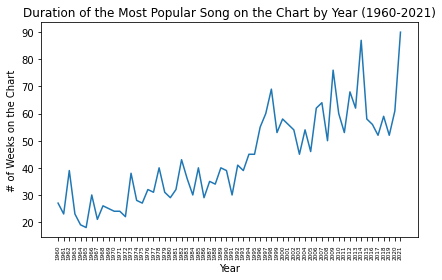

In [217]:
wks_chart_max=pd.DataFrame(wks_chart.groupby('year').wks_chart.max())
plt.plot(wks_chart_max.index, wks_chart_max.wks_chart)
#fig, ax = plt.subplots()
#ax.plot_date(wks_chart_trend.index, wks_chart_trend.wks_chart)
#fig.autofmt_xdate()
plt.xticks(rotation=90, fontsize = 'xx-small')
plt.xlabel('Year')
plt.ylabel('# of Weeks on the Chart')
plt.title('Duration of the Most Popular Song on the Chart by Year (1960-2021)')
plt.tight_layout()

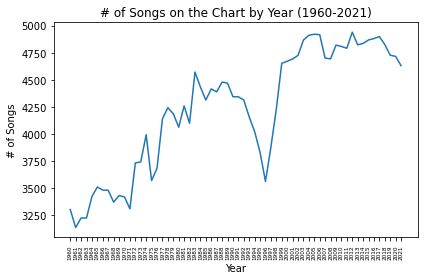

In [218]:
wks_chart_counts=pd.DataFrame(songs.groupby(['year']).count())
plt.plot(wks_chart_counts.index, wks_chart_counts.g_url)
plt.xticks(rotation=90, fontsize = 'xx-small')
plt.xlabel('Year')
plt.ylabel('# of Songs')
plt.title('# of Songs on the Chart by Year (1960-2021)')
plt.tight_layout()

#### B. Song Lyric Visualization

We then decided to visualize the song lyrics in relation to one another using SVD. To do this, we first set up a decades column using the date column from before in order to have a have another variable to group the visualization by. Then, we used a count vectorizer to fit the song lyrics, and plotted all the songs together, then the songs grouped by decade, and then each the songs of decade separately.

In [38]:
# drop duplicates and na values
songs_trun=songs[['lyrics']].drop_duplicates()
songs_trun.dropna(inplace=True)

# add year column to dataframe without duplicates
same_songs = songs.groupby('lyrics')
years = pd.DataFrame(round(same_songs.year.median()))
songs_trun=songs_trun.merge(years, on='lyrics')

In [40]:
print('Number of unique songs scraped:', len(songs_trun))
songs_trun['decade']=songs_trun['year'].astype(str)
songs_trun['decade'] = (songs_trun['decade'].str[0:3].astype(int))*10
songs_trun.head()

Number of unique songs scraped: 21950


lyrics    year  decade
0  Out in the West Texas town of El PasoI fell in...  1960.0    1960
1  I'll never let you goWhy? Because I love youI'...  1960.0    1960
2  On the bank of the riverStood Running Bear, yo...  1960.0    1960
3  Heartaches by the number, troubles by the scor...  1960.0    1960
4  When somebody leaves you, that's the time to c...  1960.0    1960

In [41]:
# Vectorize for the sake of SVD 

vectorizer = CountVectorizer( #token counts
    input = 'content',
    #preprocessor=pre_proc,
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', 
    lowercase = True,
    min_df = 0.01, #chunk by song
    max_df = 0.9    
)

X = vectorizer.fit_transform(songs_trun['lyrics'])
print("Feature matrix shape:", X.shape)
print("Total vectorized words in the corpus:", X.sum())
print("Average vectorized song length:", int(X.sum()/X.shape[0]), "tokens")

Feature matrix shape: (21950, 1130)
Total vectorized words in the corpus: 4429954
Average vectorized song length: 201 tokens


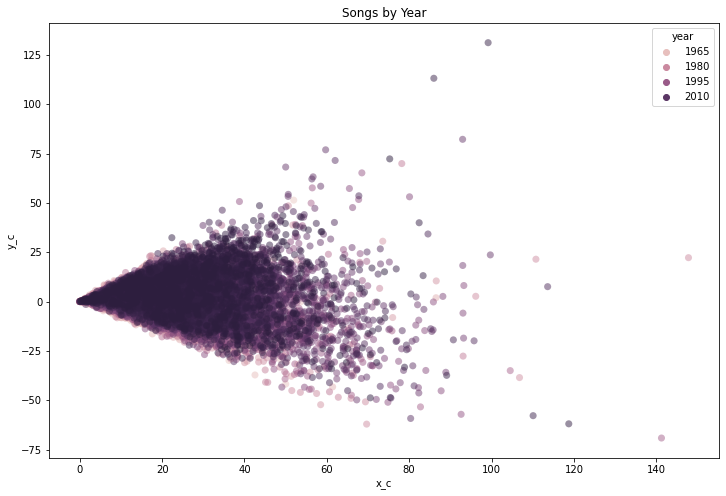

In [42]:
# by year
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['year'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Songs by Year')
plt.show()

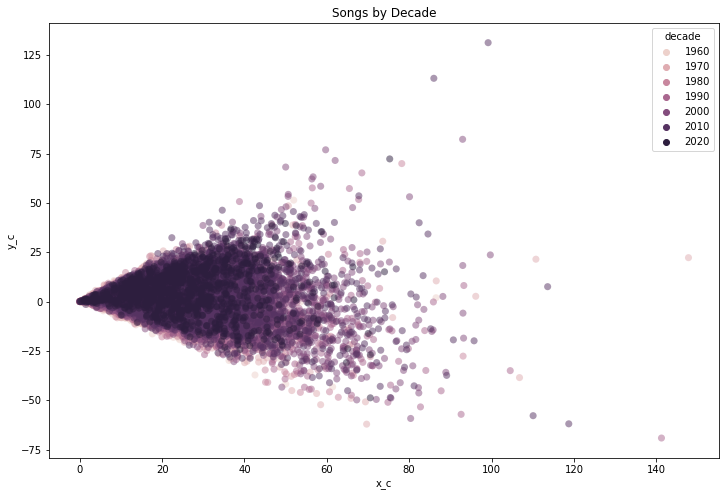

In [43]:
# by decade
song_vis = TruncatedSVD(n_components=2).fit_transform(X)

songs_trun['x_c']=song_vis[:,0]
songs_trun['y_c']=song_vis[:,1]

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=songs_trun['x_c'], 
    y=songs_trun['y_c'],
    hue=songs_trun['decade'],
    #style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Songs by Decade')
plt.show()

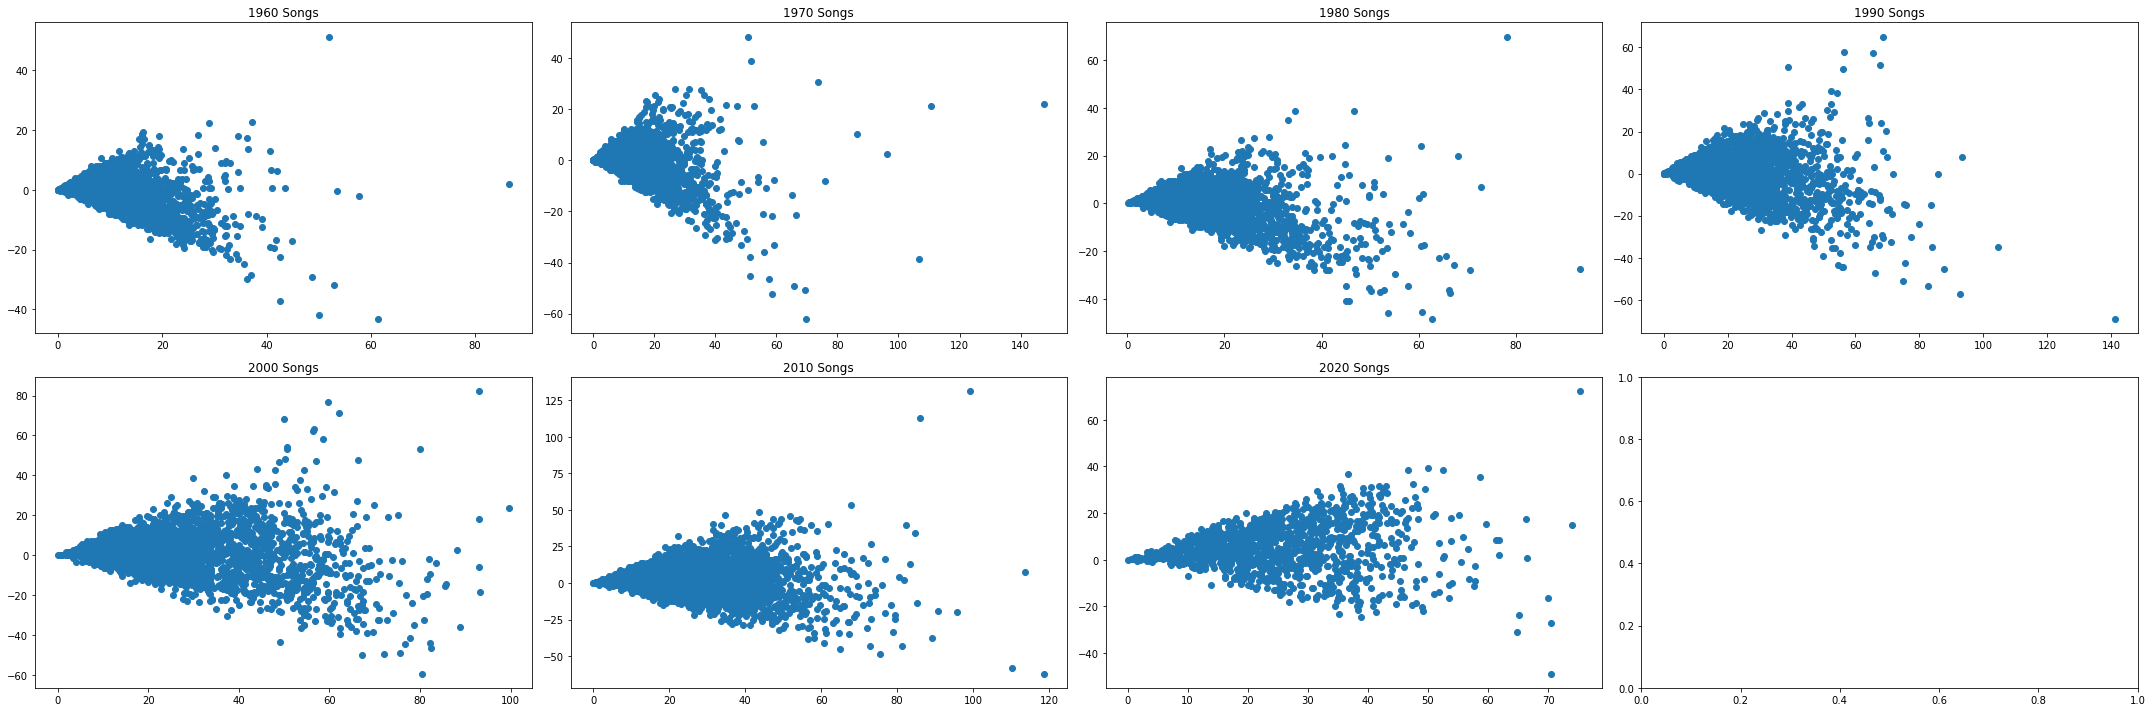

In [44]:
# separate each decade

x=0
fig, axs = plt.subplots(2, 4, figsize=(30,10))
axs = axs.ravel()
for decade in sorted(songs_trun['decade'].unique()):
    axs[x].scatter(songs_trun[songs_trun.decade == decade]['x_c'], songs_trun[songs_trun.decade == decade]['y_c'])
    axs[x].set_title(f'{decade} Songs')
    x+=1
plt.tight_layout()
plt.show()

We can see from these graphs that the general shape of the distribution of songs is relatively constant through the years. For each decade, we can see that the main cluster of songs is about the origin of the graph, with a funnel shape spreading outwards. For some decades, however, the distribution of song lyrics extends much further, suggesting that in those years, the song lyrics of the top 100 songs were less homogeneous than for other years. The graph with the shortest range of x values is the decade of 2020, but this is likely because there is not much data for this decade, considering we are only in the 2 year of the decade, and it is not yet half over. Therefore, if we look at the decade with the second shortest range of x values, we see that it is the 1960s. In looking into the music of 1960s, the cohesiveness of the songs makes sense, as the music scene in the 1960s was largely dominated by rock music, pop rock, psychdelic rock, blues rock, or folk rock. The American rock music of the 60s saw a merging of the rock scene from the decade before into a more international variant, which could help explain the similarities between the song lyrics, as mainstream rock music could have tackled similar contents (https://en.wikipedia.org/wiki/1960s_in_music).

#### C. Which songs are the closest together and which ones are the farthest apart from the rest?
To investigate this further, we decided to look into both the songs that were clustered right at the origin as well as the songs farthest away from the origin. We found the min and max of the y values and the max x value to see which songs there were. The songs that were the farthest outliers in 1960 were 'Ride!' by Dee Dee Sharp, 'By the Time I get To Phoenix' by Isaac Hayes, and 'You' by Marvin Gaye. None of these songs held a number one position on the chart at its peak, althought 'Ride!' was the highest with a peak position of 5. In addition, none of the songs were close to holding the longest time on the chart. In the 60s, the songs that held the record for the longest time on the chart was 'The Twist' by Chubby Checker', at 39 weeks. The longest among the three farthest outliers was again 'Ride!' with 13 weeks on the chart. We also looked at the songs that were clustered right at the origin. We found that these songs were probably clustered around here because they are either very short or repetitive. For example, the Batman Theme is less than one stanza long, and only contains the words "Batman" and "da". Another reason could be the fact that the song is in a different language, and thus the lyrics were not processed correctly because our methods do not allow us to, such as '上を向いて歩こう' (Sukiyaki). However, Sukiyaki held a number one position on the chart, and was on the chart for 14 weeks, a higher position and longer time than any other song in the cluster.

#### The Music of the 60s

In [102]:
songs1960=songs_trun[songs_trun['decade']==1960]
outlier1960=songs1960[songs1960['y_c']==max(songs1960['y_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==outlier1960[0]]

rank        date  title        artist1 artist2  peak_pos  wks_chart  \
9750    41  1963-01-12  Ride!  Dee Dee Sharp     NaN         5         13   

                                                  b_url  \
9750  https://www.billboard.com/charts/hot-100/1963-...   

                                                 g_url  \
9750  https://www.genius.com/Dee-Dee-Sharp-Ride-lyrics   

                                                 lyrics  year decade  
9750  Let's pony again(Get it, get it, get it, get i...  1963   1960

In [103]:
talloutlier1960=songs1960[songs1960['x_c']==max(songs1960['x_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==talloutlier1960[0]]

rank        date                         title      artist1 artist2  \
32864    37  1969-10-18  By The Time I Get To Phoenix  Isaac Hayes     NaN   

       peak_pos  wks_chart                                              b_url  \
32864        37          8  https://www.billboard.com/charts/hot-100/1969-...   

                                                   g_url  \
32864  https://www.genius.com/Isaac-Hayes-By-The-Time...   

                                                  lyrics  year decade  
32864  Awww, yeahMmmm, hmmm, hmmm, mmmm, mmmm, mmmm, ...  1969   1960

In [104]:
shortoutlier1960=songs1960[songs1960['y_c']==min(songs1960['y_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==shortoutlier1960[0]]

rank        date title      artist1 artist2  peak_pos  wks_chart  \
27227    47  1968-02-24   You  Marvin Gaye     NaN        34          7   

                                                   b_url  \
27227  https://www.billboard.com/charts/hot-100/1968-...   

                                               g_url  \
27227  https://www.genius.com/Marvin-Gaye-You-lyrics   

                                                  lyrics  year decade  
27227  Ooh, you, you I seeIn my mirror in the morning...  1968   1960

In [200]:
median1960 = songs1960[(songs1960['y_c'] > -.1)&(songs1960['y_c'] < .1)&(songs1960['x_c'] < 1)].sort_values(by='y_c')

nn=median1960.merge(wks_chart, on='lyrics')

print('Songs clustered at the origin: \n')
display(nn[['title', 'artist1','peak_pos', 'wks_chart']])
print(nn.g_url.values,'\n')
print('Lyrics to "Mint Julep" by Chet Atkins:')
print(nn[nn['g_url'] == 'https://www.genius.com/Chet-Atkins-One-Mint-Julep-lyrics'].lyrics.values)

print('\nLyrics to "The Batman Theme by The Marketts:')
print(nn[nn['g_url'] == 'https://www.genius.com/The-Marketts-Batman-Theme-lyrics'].lyrics.values)

Songs clustered at the origin: 



title                    artist1  peak_pos  wks_chart
0  Mr. Songwriter             Connie Stevens        43          8
1  One Mint Julep                Chet Atkins        82          6
2        Sukiyaki               Kyu Sakamoto         1         14
3           Jingo                    Santana        56          8
4     Beatnik Fly  Johnny And The Hurricanes        15         13
5     Point Panic               The Surfaris        49          8
6    Batman Theme               The Marketts        17          9
7          Milord                Bobby Darin        45          9

['https://www.genius.com/Connie-Stevens-Mr-Songwriter-lyrics'
 'https://www.genius.com/Chet-Atkins-One-Mint-Julep-lyrics'
 'https://www.genius.com/Kyu-Sakamoto-Sukiyaki-lyrics'
 'https://www.genius.com/Santana-Jingo-lyrics'
 'https://www.genius.com/Johnny-And-The-Hurricanes-Beatnik-Fly-lyrics'
 'https://www.genius.com/The-Surfaris-Point-Panic-lyrics'
 'https://www.genius.com/The-Marketts-Batman-Theme-lyrics'
 'https://www.genius.com/Bobby-Darin-Milord-lyrics'] 

Lyrics to "Mint Julep" by Chet Atkins:
['Mint JulepMint JulepMint JulepMint JulepMint JulepMint Julep']

Lyrics to "The Batman Theme by The Marketts:
['Batman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanBatman, Batman, Batman, BatmanBatman, Batman, BatmanDa da da da da da da da da da da da da da da da daBatman!']


#### The Music of the 90s

We then decided to do the same thing for the decade that had the largest distribution as well, which was the 1990s. In the 1990s, hip hop grew to be very successful in the industry. Reggae, contemporary R&B, and urban music was also very popular, and many fusion genres were created from these genres, include jack swing, neo-soul, and g-funk. Still, teen pop was extremely popular, continuing from the decade before. Rock music was also very popular, and the music scene saw the emergence of grunge, alternative rock, punk rock, and nu metal. In addition electronic music grew very popular during the 90s, with house, techno, rave, and happy hardcore reaching great success (https://en.wikipedia.org/wiki/1990s_in_music). The farthest outliers from the 1990s include the songs '1st of the Tha Month' by Bone Thugs-N-Harmony, 'Giving You The Benefit' by Pebbles, and 'Kiss You Back' by Digital Underground.

In [217]:
songs1990=songs_trun[songs_trun['decade']==1990]
outlier1990=songs1990[songs1990['y_c']==max(songs1990['y_c'])].lyrics.values
wks_chart[wks_chart['lyrics']==outlier1990[0]]

rank        date             title               artist1 artist2  \
140116    97  1996-01-06  1st Of Tha Month  Bone Thugs-N-Harmony     NaN   

        peak_pos  wks_chart  \
140116        14         20   

                                                    b_url  \
140116  https://www.billboard.com/charts/hot-100/1996-...   

                                                    g_url  \
140116  https://www.genius.com/Bone-Thugs-N-Harmony-1s...   

                                                   lyrics  year decade  
140116  Wake up, wake up, wake up, wake up, wake upIt'...  1996   1990

In [222]:
talloutlier1990=songs1990[songs1990['x_c']>100].lyrics.values
display(wks_chart[wks_chart['lyrics']==talloutlier1990[0]])
display(wks_chart[wks_chart['lyrics']==talloutlier1990[1]])

rank        date                   title  artist1 artist2  peak_pos  \
119550    94  1991-01-12  Giving You The Benefit  Pebbles     NaN         4   

        wks_chart                                              b_url  \
119550         22  https://www.billboard.com/charts/hot-100/1991-...   

                                                    g_url  \
119550  https://www.genius.com/Pebbles-Giving-You-The-...   

                                                   lyrics  year decade  
119550  Lately I've been trying to figure out your min...  1991   1990

rank        date          title              artist1 artist2  \
124758    59  1992-03-28  Kiss You Back  Digital Underground     NaN   

        peak_pos  wks_chart  \
124758        40         20   

                                                    b_url  \
124758  https://www.billboard.com/charts/hot-100/1992-...   

                                                    g_url  \
124758  https://www.genius.com/Digital-Underground-Kis...   

                                                   lyrics  year decade  
124758  Alright, let's goShimmy, shimmy cocoa popYeah,...  1992   1990

In [234]:
median1990 = songs1990[(songs1990['y_c'] > -.2)&(songs1990['y_c'] < .2)&(songs1990['x_c'] < 1)].sort_values(by='y_c')

mm=median1990.merge(wks_chart, on='lyrics')

print('Songs clustered at the origin: \n')
display(mm[['title', 'artist1','peak_pos', 'wks_chart']])
print(mm.g_url.values,'\n')
print('Lyrics to "Sadeness Part 1" by Enignma:')
print(mm[mm['g_url'] == 'https://www.genius.com/Enigma-Sadeness-Part-1-lyrics'].lyrics.values)

print('\nLyrics to "God Bless the Child by Shania Twain:')
print(mm[mm['g_url'] == 'https://www.genius.com/Shania-Twain-God-Bless-The-Child-lyrics'].lyrics.values)

Songs clustered at the origin: 



title       artist1  peak_pos  \
0                                 Sadeness Part 1        Enigma         5   
1                                        Macarena   Los Del Mar        71   
2                                   Sweet Lullaby   Deep Forest        78   
3                                         Lambada         Kaoma        46   
4                                        Macarena   Los Del Rio        23   
5  Dur Dur D'etre BeBe! (It's Tough To Be A Baby)         Jordy        58   
6                             God Bless The Child  Shania Twain        75   

   wks_chart  
0         18  
1         15  
2          8  
3         12  
4         21  
5          9  
6          5

['https://www.genius.com/Enigma-Sadeness-Part-1-lyrics'
 'https://www.genius.com/Los-Del-Mar-Macarena-lyrics'
 'https://www.genius.com/Deep-Forest-Sweet-Lullaby-lyrics'
 'https://www.genius.com/Kaoma-Lambada-lyrics'
 'https://www.genius.com/Los-Del-Rio-Macarena-lyrics'
 'https://www.genius.com/Jordy-Dur-Dur-Detre-BeBe-Its-Tough-To-Be-A-Baby-lyrics'
 'https://www.genius.com/Shania-Twain-God-Bless-The-Child-lyrics'] 

Lyrics to "Sadeness Part 1" by Enignma:
['誰もが通り過ぎてく気にも止めない どうしようもないそんなガラクタを 大切そうに抱えていた周りは不思議なカオで少し離れた場所から見てたそれでも笑って言ってくれた「宝物だ」と大きな何かを手に入れながら 失ったものもあったかな今となってはもうわからないよね取り戾したところで きっと微妙に違っているハズで君がいるなら どんな時も 笑ってるよ君がいるなら どんな時も 笑ってるよ泣いているよ 生きているよ君がいなきゃ何もなかった自分自身だったか周りだったかそれともただの時計だったかな壞れそうになってたものはガラクタを守り続ける腕は どんなに痛かったことだろう何を犧牲にしてきたのだろう決してキレイなマルにはなれないけれどね いびつに輝くよ君が見つけた 広くもない こんな道で君が見つけた 広くもない 狹くもないこんな道で どうにかして君がひとり磨きあげた君がいたから どんな時も 笑ってたよ君がいたから どんな時も 笑ってたよ泣いていたよ 生きていたよ君がいなきゃ何もなかった']

Lyrics to "God Bless the Child by Shania Twain:
['Hallelujah, hallelujahGod bless the child who suf

The subset of the songs most closely clustered around the origin for 1990 seem to all be non-English songs, except for 'God Bless the Child' by Shania Twain. Again as before, this song is highly repetitive and short, most likely why it is located so near to the rest of the songs.

### V. LDA Topic Modeling (Doc-Topic Matrix) + Prediction

With this background knowledge about the relative homogeneity of the top 100 songs per decade, we started our topic modeling. We began by testing the model with five topics and 10 iterations, and then we tried 5 topic with 15 iterations. However, for both of these models the perplexity score ended up over 250, so we decided to increase the number of topics to try and lower the perplexity score. We then tried a series of models, with varying combinations of topics and interations. We found the best way to get a lower perplexity was to increase the amount of iterations rather than to drastically increase the number of topics because when examining the topics, the more we had, the less meaningful each one became. When evaluating the model at 15 topics, we could not find discernable differences between many of them, so we decided to go with and LDA model that used 10 topics with 20 iterations. 

In [56]:
# code from lec 20-21

In [246]:
lda = LatentDirichletAllocation(
    n_components=5, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 285.0884
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 276.3640
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 274.1344
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 273.1273
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 272.4254


LatentDirichletAllocation(evaluate_every=2, n_components=5, n_jobs=-1,
                          verbose=1)

In [245]:
lda = LatentDirichletAllocation(
    n_components=5, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=15,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15, perplexity: 287.7360
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15, perplexity: 277.7622
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15, perplexity: 274.0100
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15, perplexity: 271.8705
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15, perplexity: 270.5569
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15, perplexity: 269.7693
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15, perplexity: 269.2805
iteration: 15 of max_iter: 15


LatentDirichletAllocation(evaluate_every=2, max_iter=15, n_components=5,
                          n_jobs=-1, verbose=1)

In [48]:
lda = LatentDirichletAllocation(
    n_components=8, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 285.9695
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 273.0365
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 268.5747
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 266.4145
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 265.1312


LatentDirichletAllocation(evaluate_every=2, n_components=8, n_jobs=-1,
                          verbose=1)

In [247]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=10,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 278.0262
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 266.5935
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 262.5383
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 260.5479
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 259.3315


LatentDirichletAllocation(evaluate_every=2, n_jobs=-1, verbose=1)

In [29]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=15,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 15
iteration: 2 of max_iter: 15, perplexity: 283.3507
iteration: 3 of max_iter: 15
iteration: 4 of max_iter: 15, perplexity: 269.6622
iteration: 5 of max_iter: 15
iteration: 6 of max_iter: 15, perplexity: 265.3600
iteration: 7 of max_iter: 15
iteration: 8 of max_iter: 15, perplexity: 263.3425
iteration: 9 of max_iter: 15
iteration: 10 of max_iter: 15, perplexity: 262.0556
iteration: 11 of max_iter: 15
iteration: 12 of max_iter: 15, perplexity: 260.9540
iteration: 13 of max_iter: 15
iteration: 14 of max_iter: 15, perplexity: 260.2704
iteration: 15 of max_iter: 15


LatentDirichletAllocation(evaluate_every=2, max_iter=15, n_jobs=-1, verbose=1)

In [49]:
lda = LatentDirichletAllocation(
    n_components=15, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=20,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20, perplexity: 276.0380
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20, perplexity: 262.8682
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20, perplexity: 258.6221
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20, perplexity: 256.5541
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 255.2997
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20, perplexity: 254.4736
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20, perplexity: 253.8959
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20, perplexity: 253.4544
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20, perplexity: 253.0912
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 252.8064


LatentDirichletAllocation(evaluate_every=2, max_iter=20, n_components=15,
                          n_jobs=-1, verbose=1)

In [50]:
lda = LatentDirichletAllocation(
    n_components=10, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=20,     # Might want more in production work
    evaluate_every=2 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20, perplexity: 282.8618
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20, perplexity: 268.2793
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20, perplexity: 262.6380
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20, perplexity: 260.0462
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 258.6369
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20, perplexity: 257.8577
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20, perplexity: 257.3782
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20, perplexity: 257.0568
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20, perplexity: 256.8136
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 256.6065


LatentDirichletAllocation(evaluate_every=2, max_iter=20, n_jobs=-1, verbose=1)

In [51]:
# source: lecture 20-21 topic models

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

#### 10 Selected Topics
The topics that we ended up with are shown below. Some of the major characteristics of the topics are clear from the top 15 words of the topics. For example, topic 0 has many words relating to woman (she, her, girl) and topic 4 has words relating to men (he, man, his). Futher, topic 6 is likely constructed from words that are related to relationships, given the words 'love', 'you' 'me', need', 'heart', and 'take'. and topic 8 is likely constructed from ad-libs or filler type words like 'la', 'na', 'woah', and 'yeah'. Looking at the pyLDAvis output, we can see that the topic constructed with ad-libs is the farthest apart from the rest of the topics. It makes sense that this topic is the farthest away from the others inter-topic wise because the these words are most likely the least related to the others considering they are not actually words.

In [58]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=20, hide_stops=False)

Topic  0: she yeah her ooh girl that got me like said bad so my and know woman it was just woah
Topic  1: my me be in on can da of life ll feel with and am by got all just you so
Topic  2: we it and all ve be that is this of time for in can just never no ll been re
Topic  3: you don do it me baby what wanna want know gonna can make say just be and got if give
Topic  4: and of in he was is on they that for all man his little at out him with are from
Topic  5: you me re that know can your so for never like just ve my when see what if it be
Topic  6: love you your me ll and in be of will for my is need can with heart that let take
Topic  7: that my in it on you like and up ain with me got they get for we no all don
Topic  8: oh la na no hey ah me whoa ha uh de yeah hoo mi ooh yo ohoh ya woah baby
Topic  9: it on get up and you your down like let go come that got back all can we in me



In [59]:
pyLDAvis.enable_notebook()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_vis = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='pcoa', sort_topics=False)
pyLDAvis.display(lda_vis)

/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/gabychu/opt/anaconda3

### A. Doc-Topic Matrix

In [60]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (21950, 10)


#### a. Correlation Plot

Our doc-topic matrix is (21950, 10), representing the distribution of each of the 10 topics across the 21950 songs. Using this matrix, we first did some exploratory data analysis. We made a correlation plot, which showed that the none of the topics have a positive correlation, but most do have a slightly negative correlation. The one with the highest negative correlation was topic 6 and 7 (5 and 6 in the list above). This was interesting because inter-topic wise, they overlap quite a bit, but topic 6 (5) contains more words that can be negatively associated, such as 'never', 'give', 'away'. This could make sense because the songs in the different topics could both be talking about relationships, but with a different tone, reflected in the featured words.

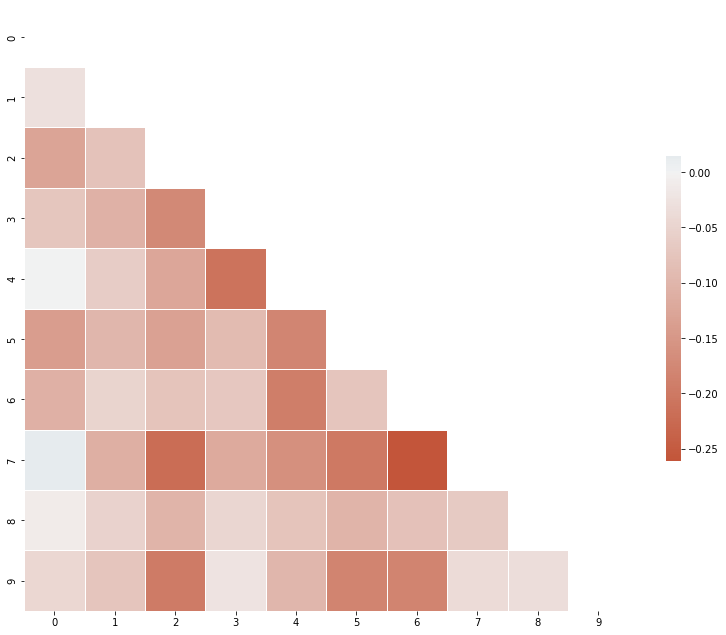

In [62]:
# source lec 20-21
corr = np.corrcoef(doc_topic_matrix.T)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

#### b. Time Series by Topic

We also decided to plot the songs by time to see if the topics were more popular in songs of certain years. Many of the songs have a temporal trend. For example, the graph of the distribution of topics per year for topic 7 sees a sharp rise in the 1990s, with another, sharper rise in the mid 2010s. Looking into the words for this topic, it sharp increase of the topic does make sense. The topic, unlike the others, contains a mixture of swear words and slurs. Accorinding to a study on the use of profanity on the American Billboard Charts, the use of this profanity in songs is most widespread in the pop and rap/hip hop genre, with artists like A$AP Rocky, Drake, Kendrick Lamar, and Nicki Minaj having the songs with the most profanity. In addition, the article states the years where the songs with the most profanity follow a general pattern of the early 2010s (2012 and 2013) and the later 2010s (2017 and 2018), which would explain the sharp spike during this decade. Additionally, to make get a clearer look at individual song counts and information, we printed a subset of the song for year decade as well as histogram to show the counts of each topic per decade. The topic that dominated the most songs was topic 7, which featured words include 'that', 'my', 'like', and 'with'. These words seem rather broad; there is not much unique meaning that can be taken from these specific words, so it makes sense that this would be present in a very large number of songs
<br>
Source: http://www.ijstr.org/final-print/feb2020/and-I-Swear-Profanity-In-Pop-Music-Lyrics-On-The-American-Billboard-Charts-2009-2018-And-The-Effect-On-Youtube-Popularity.pdfhttp://www.ijstr.org/final-print/feb2020/and-I-Swear-Profanity-In-Pop-Music-Lyrics-On-The-American-Billboard-Charts-2009-2018-And-The-Effect-On-Youtube-Popularity.pdf 

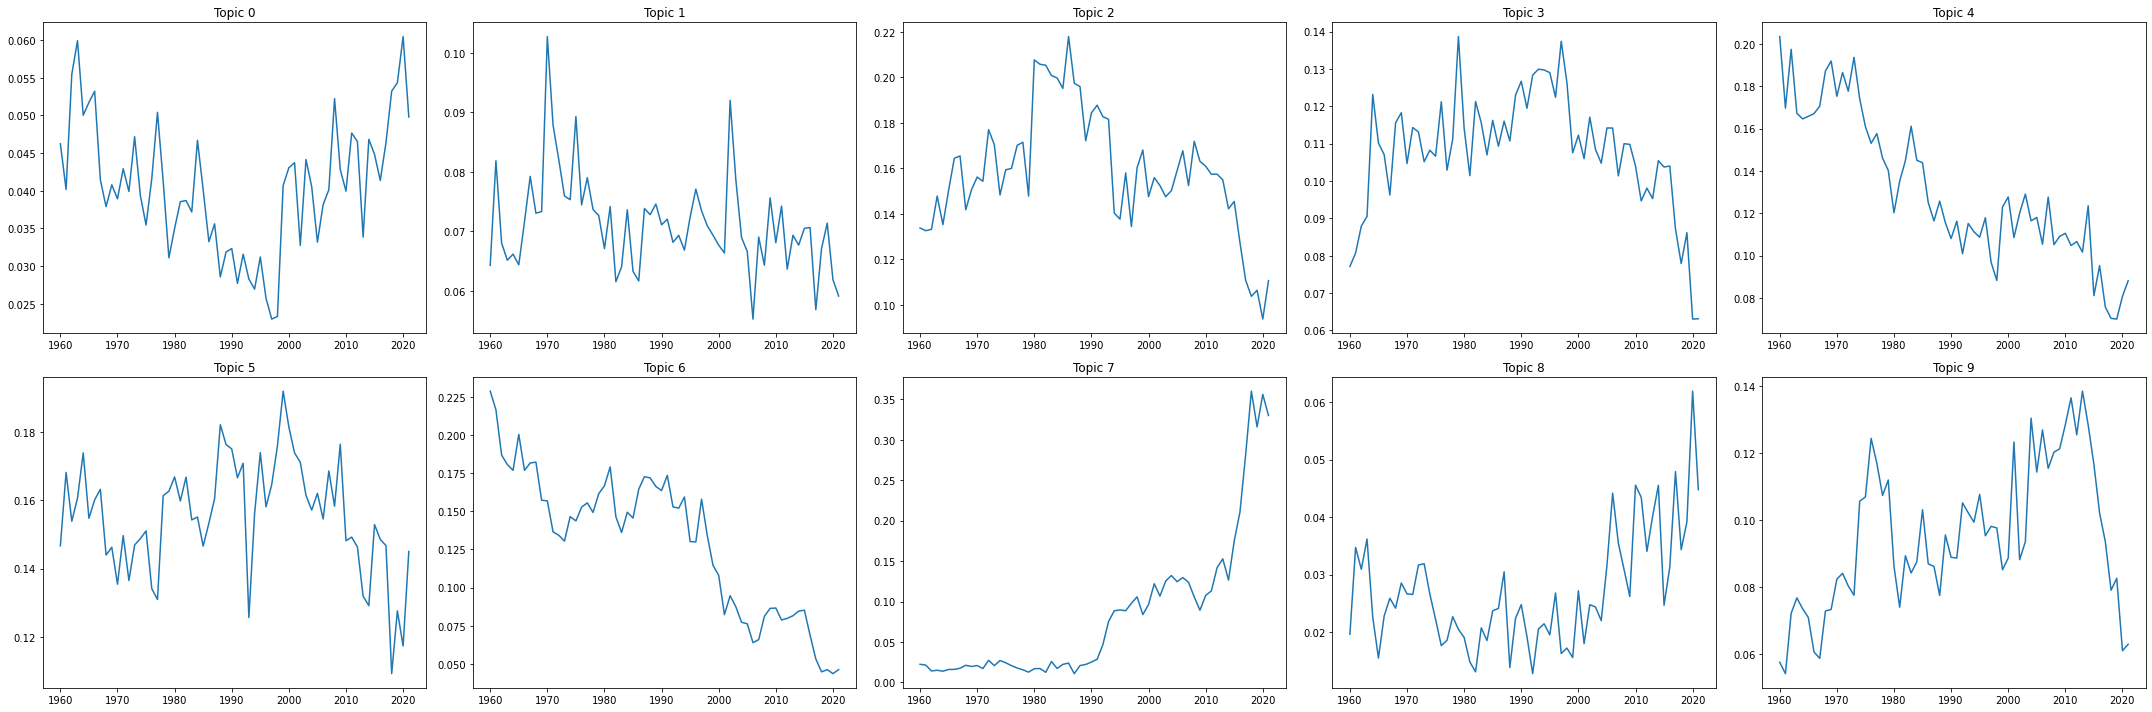

In [116]:
# Time series
n_cols = 5
n_topics = doc_topic_matrix.shape[1]
n_rows = n_topics/n_cols
if n_rows%1!=0:
    n_rows += 1
n_rows = int(n_rows)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(30,10))
axs = axs.ravel()

valid_years = sorted(np.unique(songs_trun.year))


for topic in range(n_topics):
    topic_data = doc_topic_matrix[:,topic]
    topic_means = []
    for year in valid_years:
        mask = np.equal(songs_trun['year'], year)
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].plot(valid_years, topic_means)
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

In [118]:
biggest_topic = []
max_value = max(doc_topic_matrix[song])
max_index = doc_topic_matrix[song].tolist().index(max_value)
biggest_topic.append(max_index)

In [119]:
subset_vis = songs_trun.merge(wks_chart, on='lyrics')

artist1            title  year_x  \
15252          Beck             Girl  2005.0   
20846    Mac Miller      Complicated  2020.0   
7018    Wild Cherry  I Love My Music  1978.0   
6319          Sweet           Action  1976.0   
1099   Frank Ifield   Lovesick Blues  1963.0   

                                                  lyrics  topic  
15252  I saw her, yeah I saw her with her black tongu...      0  
20846  Outside is cloudy, but I like that better (Bet...      0  
7018   Doo doo doo doo dooDoo doo doo doo dooDoo doo,...      0  
6319   So you think you'll take another piece of meTo...      0  
1099   I got a feeling called the blues lordSince my ...      0

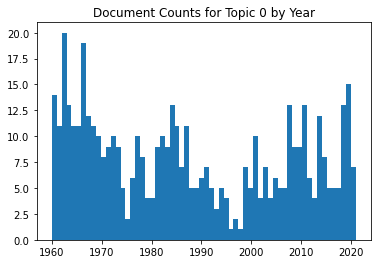

artist1                               title  year_x  \
6606      The Supremes             You're My Driving Wheel  1976.0   
14243     Kevin Denney                  That's Just Jessie  2002.0   
6091      Elvin Bishop                     Sure Feels Good  1975.0   
17443    Blake Shelton                   I Won't Back Down  2011.0   
12988  Backstreet Boys  Quit Playing Games (With My Heart)  1997.0   

                                                  lyrics  topic  
6606   You're my driving wheelFeels good, babyYou tak...      1  
14243  Sometimes in the morningMy coffee gets ice col...      1  
6091   I never seen such a beautiful dayLooked like e...      1  
17443  Well, I won't back downNo, I won't back downYo...      1  
12988  Baby, oh-ohEven in my heart, I seeYou're not b...      1

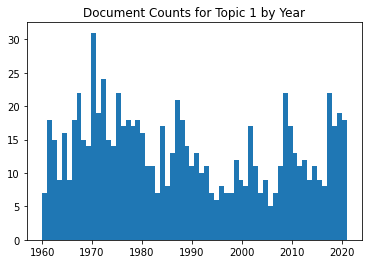

artist1               title  year_x  \
7182      Linda Ronstadt  Back In The U.s.a.  1978.0   
17405      Kenny Chesney     You And Tequila  2011.0   
12932  Merril Bainbridge     Under The Water  1997.0   
20049        Keith Urban         Coming Home  2018.0   
10234     Glenn Medeiros   Watching Over You  1987.0   

                                                  lyrics  topic  
7182   Oh well, oh wellI feel so good todayWe just to...      2  
17405  Baby, here I am againKicking dust in the canyo...      2  
12932  I get confusedWhen I'm tiredBut the last time ...      2  
20049  I wake up feeling, in my soul I'mLiving someon...      2  
10234  Now that you're far awayI can see everything s...      2

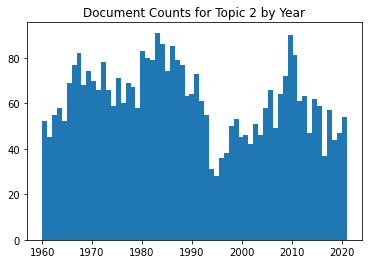

artist1                  title  year_x  \
10761     Rick Astley      Giving Up On Love  1989.0   
1970          Joe Tex  You Got What It Takes  1965.0   
8988     Robert Plant            In The Mood  1983.0   
12464  Crystal Waters            What I Need  1995.0   
15863       Timbaland          The Way I Are  2007.0   

                                                  lyrics  topic  
10761  Giving up on loveGiving up on loveI was so cra...      3  
1970   Some boys say they like your eyesI heard some ...      3  
8988   I'm in the mood for a melodyI'm in the mood fo...      3  
12464  I said I'm tired and I must complainI said I'm...      3  
15863  State of emergencyYeah, yeah (Yeah)Yeah, yeah ...      3

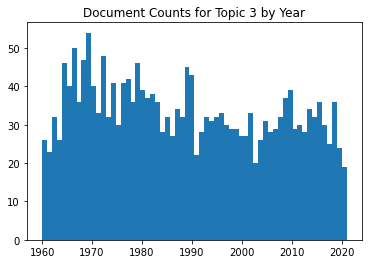

artist1                  title  year_x  \
15550  Five For Fighting             The Riddle  2006.0   
2895        Percy Sledge      Out Of Left Field  1967.0   
17924      Kenny Chesney       El Cerrito Place  2012.0   
21621     Olivia Rodrigo             Hope Ur OK  2021.0   
1265           The Essex  Easier Said Than Done  1963.0   

                                                  lyrics  topic  
15550  There was a man back in '95Whose heart ran out...      4  
2895   When least expectedFate stumbles inBringing li...      4  
17924  I been hanging round this place, I been lookin...      4  
21621  I knew a boy once when I was smallA towhead bl...      4  
1265   My friends all tell meGo to him, run to himSay...      4

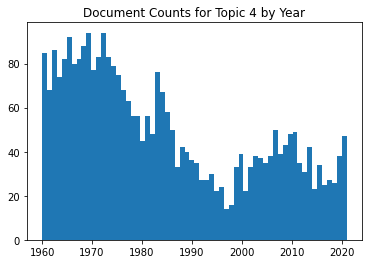

artist1                                       title  \
1410   Ruby And The Romantics  Young Wings Can Fly (Higher Than You Know)   
15936               The-Dream                              Shawty Is A 10   
5130           Donny Hathaway       I Love You More Than You'll Ever Know   
14487                  Common                            Come Close To Me   
10374                The Cars                               Coming Up You   

       year_x                                             lyrics  topic  
1410   1963.0  Young wings can flyYoung wings can flyYoung wi...      5  
15936  2007.0  Shawty Rock To The Beat For Ya BoyShawtyDo ItR...      5  
5130   1972.0  If I ever leave you baby, you can say I told y...      5  
14487  2003.0  It's just a fly love song, whatIt's just a fly...      5  
10374  1988.0  How could they leave you standingHolding on to...      5

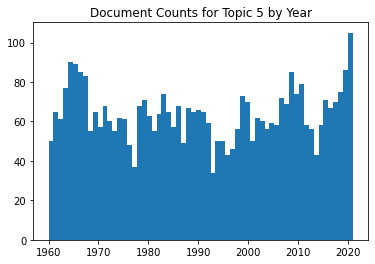

artist1                        title  year_x  \
9991   Samantha Fox  Touch Me (I Want Your Body)  1987.0   
15443    The Afters               Beautiful Love  2006.0   
5806   Bobby Vinton            My Melody Of Love  1974.0   
9664          Sting     Love Is The Seventh Wave  1985.0   
13041       Rockell                   In A Dream  1998.0   

                                                  lyrics  topic  
9991   Ah, touch me, touch meThis is the nightTouch m...      6  
15443  Far away, I feel your beating heartAll alone, ...      6  
5806   I'm lookin for a place to go so I can be all a...      6  
9664   In the empire of the sensesYou're the queen of...      6  
13041  Sweetheart, I can't stop thinking about youYou...      6

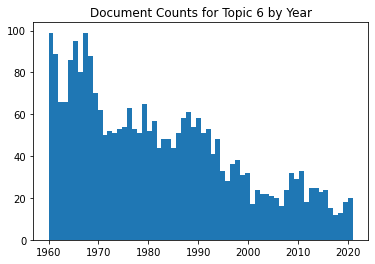

artist1           title  year_x  \
14605  Hitman Sammy Sam      Step Daddy  2003.0   
19786            Eminem     Untouchable  2017.0   
18487           Jeremih  Don't Tell 'Em  2014.0   
20635        Young Thug     Light It Up  2019.0   
20632        Young Thug            Surf  2019.0   

                                                  lyrics  topic  
14605  This for the step-daddies hereDo the Stepdaddy...      7  
19786  Hands up, officer don't shootThen pull your pa...      7  
18487  Mustard on the beat, hoRhythm is a dancer, I n...      7  
20635  That's my man (Man)Flood my wrist with all typ...      7  
20632  WoahYou guys wanna go to the beach with a frea...      7

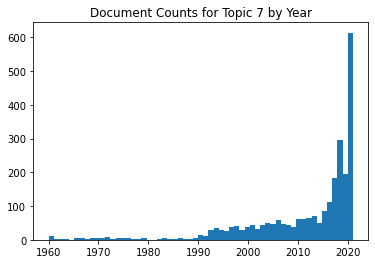

artist1           title  year_x  \
15663      Toby Love   Tengo Un Amor  2006.0   
9502       Al Corley    Square Rooms  1985.0   
15496  Rascal Flatts  Me And My Gang  2006.0   
21322        Farruko       La Toxica  2020.0   
20484       Aventura        Inmortal  2019.0   

                                                  lyrics  topic  
15663  I know that things are far from perfect, pleas...      8  
9502   Thinking in square rooms, a human without illu...      8  
15496  Way on down to southern AlabamaWith the guitar...      8  
21322  A ella ya no le motiva salirQuedó traumada, to...      8  
20484  Tu grupo favoritoNadie entiende cómo este amor...      8

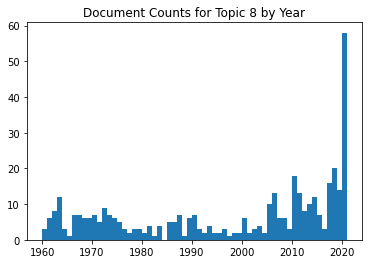

artist1            title  year_x  \
19191                David Nail  Night's On Fire  2016.0   
18071              Robin Thicke    Blurred Lines  2013.0   
13822            Jo Dee Messina   That's The Way  2000.0   
15335                   Beyonce      Check On It  2006.0   
7252   Electric Light Orchestra        It's Over  1978.0   

                                                  lyrics  topic  
19191  Cue the music out the drivewaySlow summer on a...      9  
18071  Everybody get upEverybody get upHey, hey, heyH...      9  
13822  Everybody wants an easy rideOn the merry-go-ro...      9  
15335  Swizz BeatzDC, Destiny Child (Slim Thug)You ne...      9  
7252   It's over, it's over, it's overSummer came and...      9

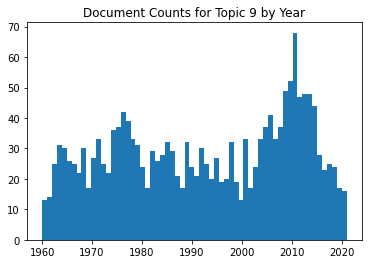

In [147]:
for topic in range(0,n_topics):
    subset = subset_vis[subset_vis['topic'] == topic]
    display(subset.sample(5)[['artist1', 'title', 'year_x', 'lyrics', 'topic']])
    x = [subset.year_x.values]
    plt.hist(x, bins = len(subset.year_x.unique()))
    plt.title(f'Document Counts for Topic {topic} by Year')
    plt.show()

Now, using these topics, we attempt to predict what year a certain song was released. We first did this using linear regression, using the song lyrics as an input to try and predict the specific year that a song was on the chart. The model performed quite badly; its mean cross-validated R^2 score was -0.013, meaning it performed worse than a horizontal line would have. This could mean that this data is more suited to different kind of prediction task, like classification, so we decided to try to do that next.

#### c. Cross-Validation Scores
With the doc-topic matrix, we test three classification tasks: linear regression predicting year and logistic regression predicting decade. As seen below, classification with the decade as the task peformed the best.

##### 1. Linear Regression predicting year

Mean cross-validated R^2 (topics): -0.013


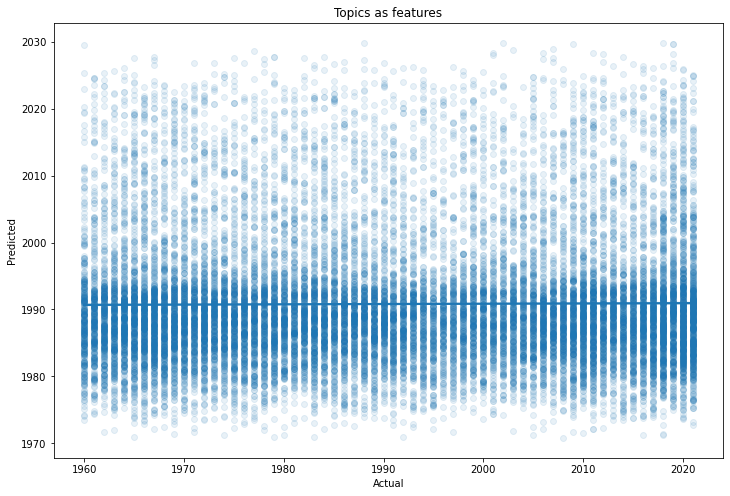

In [ ]:
# now... can we use linear regression to predict what year the song was on the chart?

# source: lec 20-21
# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)
#years = np.array(songs_trun.year).reshape(len(songs_trun.year), 1)

predictor = LinearRegression().fit(X_topics, songs_trun.year)
y_pred = predictor.predict(X_topics)

# Score
print("Mean cross-validated R^2 (topics):", round(np.mean(cross_val_score(LinearRegression(), X_topics, years,scoring='r2', cv=10)),3))

# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=years, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

##### 2. Logistic Regression predicting decade

Again using the document term matrix that was outputted from our topic model, we decided to retry the prediction task as a classification problem. We used a Logistic Regression classifier this time with max_iter set to 1000. To turn this into a classification problem, we used the decade in which the songs charted as the outcomes, and had the model predict the decade based on lyrical content. **The model score was better using this method, and improved to a score of .287.**

In [140]:
topic_clf = cross_val_score(LogisticRegression(max_iter=2000), X_topics, songs_trun['decade'], cv=10)
print("Mean 10-fold cross validated score:", round(np.mean(topic_clf),3))

Mean 10-fold cross validated score: 0.287


### VI. Word Embedding Matrix + Prediction

Our next step was to use a word embedding model in order to see if this could better predict the years in which a song charted on Billboard. In this task, we predict decade using logistic regression. 

#### A. Building the word embedding matrix

In [26]:
# word embeddings..

def remove_noninformative_tokens(doc):
    '''
    Takes a spacy-processed document.
    Returns a list of spacy token objects without stopwords, punctuation, or embedding-less tokens.
    '''
    culled = [token for token in doc if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    return(culled)

def get_doc_embedding(text, nlp):
    '''
    Takes a document as a text string and a loaded spaCy nlp object.
    Returns a vector representation of the document.
    '''
    doc = nlp(text)
    culled = remove_noninformative_tokens(doc)
    embedding = np.mean([token.vector for token in culled], axis=0)
    if np.isnan(embedding).any():
        embedding = np.zeros([1,nlp.vocab.vectors_length])
        print(f"There was a problem with document {i}\nText: {text}\n")
    return(embedding)

In [27]:
%%time
# Vectorize embeddings
import spacy
import datetime
nlp = spacy.load("en_core_web_lg")

X_embed = np.zeros([len(songs_trun), nlp.vocab.vectors_length])
for i, text in enumerate(songs_trun.lyrics):
    if i%1000 == 0:
        print(f'{i:<5} documents processed @ {datetime.datetime.now()}')
    X_embed[i] = get_doc_embedding(text, nlp)
print(X_embed.shape)

0     documents processed @ 2022-05-19 13:39:33.089856
1000  documents processed @ 2022-05-19 13:40:07.115018


/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


There was a problem with document 1226
Text: 上を向いて歩こう涙がこぼれないように思い出す春の日一人ぼっちの夜上を向いて歩こうにじんだ星を数えて思い出す夏の日一人ぼっちの夜幸せは雲の上に幸せは空の上に上を向いて歩こう涙がこぼれないように泣きながら歩く一人ぼっちの夜*Whistling*思い出す秋の日一人ぼっちの夜悲しみは星の影に悲しみは月の影に上を向いて歩こう涙がこぼれないように泣きながら歩く一人ぼっちの夜一人ぼっちの夜*Whistling*

2000  documents processed @ 2022-05-19 13:40:43.609763
There was a problem with document 2755
Text: Woo!Hey, yeah!One more timeYeah!

3000  documents processed @ 2022-05-19 13:41:18.806041
4000  documents processed @ 2022-05-19 13:41:57.434652
There was a problem with document 4581
Text: MandrillMandrillMandrillMandrillMandrill

5000  documents processed @ 2022-05-19 13:42:38.621596
6000  documents processed @ 2022-05-19 13:43:22.979288
7000  documents processed @ 2022-05-19 13:44:08.117976
8000  documents processed @ 2022-05-19 13:44:54.863368
9000  documents processed @ 2022-05-19 13:45:41.229406
10000 documents processed @ 2022-05-19 13:46:30.671934
11000 documents processed @ 2022-05-19 13:47:21.861226
There was a problem with document 113

#### B. Word Embedding Classification

After getting the word embedding matrix, we fit a a logistic regression classifier to the data. To find the optimal parameters of the classifier, we used GridSearchCV find different penalties, solvers, and max_iter parameters. For most combinations of parameters, the max_iter was not high enough, so the solver did not converge (hence all the warnings), but continually running GridSearch was becoming very computational and time expensive, so we went with the best parameters the GridSearch output, despite others not converging. It was found that the optimal parameters were {'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cg'}, so this is what we decided to use for our logistic regression, and the model achieved a mean 10-fold cross validation score of .355. 

In [44]:
%%time
# grid search for optimal classification parameters
logreg = LogisticRegression()
params = {
    'penalty': ['l2', 'none'],
    'solver':['saga', 'lbfgs', 'newton-cg'],
    'max_iter':[2000, 3000, 4000, 5000] # not part of the search, but set a classifier parameter
}
clf = GridSearchCV(logreg, params, n_jobs=-1)

# work with a subset of the data, to speed things up
X_train, X_test, y_train, y_test = train_test_split(X_embed, songs_trun['decade'], train_size = 2000)

# perform grid search
with warnings.catch_warnings() as w:
    warnings.simplefilter("ignore")
    clf.fit(X_train, y_train) # subset 

/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gabychu/opt/anaconda3/envs/3350/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

CPU times: user 2.96 s, sys: 821 ms, total: 3.78 s
Wall time: 16min 24s


In [45]:
# find the best parameters to use
clf.best_params_

{'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cg'}

#### C. Cross-Validation Score
**By predicting decade using the word embedding matrix, the cross-validation score was about .36**

In [46]:
X_embed_scaled = StandardScaler().fit_transform(X_embed)
embed_scaled_scores = cross_val_score(LogisticRegression(max_iter=2000, penalty='l2', solver='newton-cg'), X_embed_scaled, songs_trun['decade'], cv=10)
print("Mean 10-fold Logistic Regression score embedding features:", np.mean(embed_scaled_scores))

Mean 10-fold Logistic Regression score embedding features: 0.3551708428246014


### VII. Word Counts (Bag of Words) Matrix + Prediction

In addition to word embeddings, we also wanted to compare the prediction quality of the doc-topic matrix to a regular word counts (bag of words) matrix. As seen below, the maximum features of this matrix is only 159 and the cross validation score was the best when running the vectorizer over all the features. The prediction tasks we test with this matrix are linear regression with the year, classification with the year, and classification with the decade. Classification with the decade as a task outperformed the other two.

In [45]:
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    min_df=0.1,
    max_df=0.9,
    norm='l2',
    use_idf=True,)

In [46]:
X = vectorizer.fit_transform(songs['lyrics'])
X_train = StandardScaler().fit_transform(X.todense())
print("Matrix shape:", X_train.shape)
print("Mean scaled value:", np.mean(X_train))

C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Matrix shape: (262021, 159)
Mean scaled value: -2.2059674688123217e-15


In [48]:
## Gold labels
y_year=songs.year.values
y_decade=songs.decade.values

#### A. Prediction with linear regression, predicting year

In [53]:
print('10-fold cv score:', np.mean(cross_val_score(LinearRegression(), X_train, y_year, scoring='r2', cv=10)))

10-fold cv score: -87.67238981552244


#### B Classification with logistic regression, predicting year

In [50]:
print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), X_train, y_year, cv=10)))

10-fold cv score: 0.10367502891609146


#### C. Classification with logistic regression, predicting decade
Because this classification task scored the best, this is the task we went with to tune the vectorizer.

In [51]:
print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), X_train, y_decade, cv=10)))

10-fold cv score: 0.3231154051967059


In [70]:
matrix_n= []
feat_n = [50,100,120,150]
for x in feat_n:
    print(x)
    vect = TfidfVectorizer(
        encoding='utf-8',
        min_df=0.1,
        max_df=0.9,
        norm='l2',
        use_idf=True,
        max_features=x)
    matrix = vect.fit_transform(songs['lyrics'])
    X_train_Z = StandardScaler().fit_transform(matrix.todense())
   # dict_key=str(x)
    matrix_n.append(X_train_Z)

50


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


100


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


120


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


150


C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\hoope\anaconda3\envs\3350\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


#### D. Testing multiple feature inputs
**After testing multiple feature inputs, we found that using all the features performed has the best cross validation score at .32**

In [73]:
for x in range(len(matrix_n)):
    print("Number of features:",feat_n[x])
    print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), matrix_n[x], y_decade, cv=10)))

Number of features: 50
10-fold cv score: 0.29136599820237674
Number of features: 100
10-fold cv score: 0.3146809731432207
Number of features: 120
10-fold cv score: 0.31640984778200787
Number of features: 150
10-fold cv score: 0.3205698074584874


## 3. Results

#### I. Evaluating Doc Topic Matrix 
##### Linear Regression Performance
As shown in the methods above, the linear regression model performed rather poorly. The regression line consistently predicted songs to be on the chart around the 1990 throughout the six decades. In addition, most of the predictions were for years before 1990, with the number of predictions getting sparser as the years increased. However, the poor model performance could indicate that the data is not suited for a linear regression. This could be because music does not change that significantly from year to year, meaning that using each year as the output of a prediction could be the reason why the model is performing poorly. Realistically, music trends, like the song lyrics we are analyzing here, can only been seen over a wide period of time, not just one year. 

Mean cross-validated R^2 (regression task): -0.013


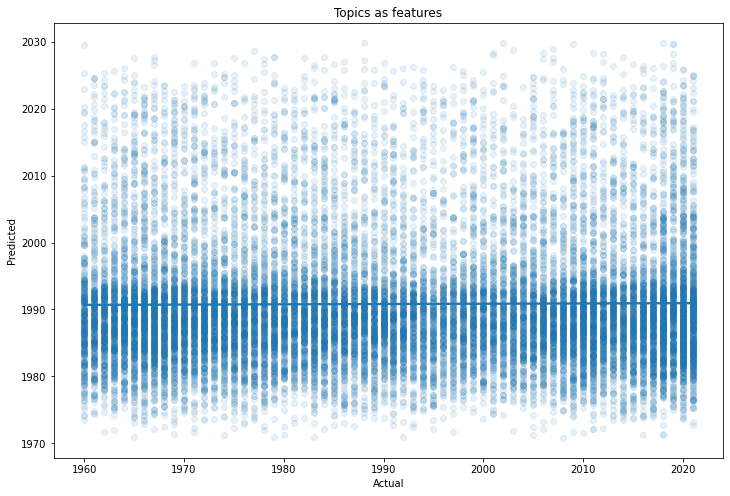

In [137]:
# now... can we use linear regression to predict what year the song was on the chart?

# source: lec 20-21
# Fit and predict using topics
X_topics = StandardScaler().fit_transform(doc_topic_matrix)
#years = np.array(songs_trun.year).reshape(len(songs_trun.year), 1)

predictor = LinearRegression().fit(X_topics, songs_trun.year)
y_pred = predictor.predict(X_topics)

# Score
print("Mean cross-validated R^2 (regression task):", round(np.mean(cross_val_score(LinearRegression(), X_topics, years,scoring='r2', cv=10)),3))

# Plot
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x=years, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Topics as features")
plt.show()

##### Classification Performance
Again, as shown in the methods section above, the model score when using a logisitic regression classifier was higher compared to using linear regression to predict song year. This could be because the issue we had with linear regression was individual years was too specific to fit on, and breaking it down by decade would make it easier for the model to predict a time range. Because this classifier would be predicting on a larger chuck on time (10 years), it makes sense that the cross validation score increase because a larger period of time would presumably allow for more distinction in lyrical content. 

In [136]:
topic_clf = cross_val_score(LogisticRegression(max_iter=1000), X_topics, songs_trun['decade'], cv=10)
print("Mean 10-fold cross validated score using Logisitic Regression (classification task):", round(np.mean(topic_clf),3))

Mean 10-fold cross validated score using Logisitic Regression (classification task): 0.287


#### II. Evaluating Word Embedding Matrix
##### Classification Performance using GridSearch

For our word embedding model, we used GridSearch in order to try the best parameters to fit our logisitic regression classifier onto. The parameters {'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cg'} that the model returned gave a model score of .35517. However, because this model was only trained a subset of the data for because it took a long time for each iteration to run, there was the possibility that these were not the optimized parameters when it came to the full dataset. In testing out some other sets of parameters for our data, we actually found that setting the penalty to 'none' with the other parameters set the same actually returned a slightly higher cross validated score of .35544, which is the highest score that we ened up achieving with this matrix and classifier.

In [46]:
X_embed_scaled = StandardScaler().fit_transform(X_embed)
embed_scaled_scores = cross_val_score(LogisticRegression(max_iter=2000, penalty='l2', solver='newton-cg'), X_embed_scaled, songs_trun['decade'], cv=10)
print("Mean 10-fold Logistic Regression score embedding features:", np.mean(embed_scaled_scores))

Mean 10-fold Logistic Regression score embedding features: 0.3551708428246014


In [48]:
X_embed_scaled = StandardScaler().fit_transform(X_embed)
embed_scaled_scores = cross_val_score(LogisticRegression(max_iter=3000, penalty='none', solver='newton-cg'), X_embed_scaled, songs_trun['decade'], cv=10)
print("Mean 10-fold Logistic Regression score embedding features:", np.mean(embed_scaled_scores))

Mean 10-fold Logistic Regression score embedding features: 0.35544419134396354


#### III. Evaluating Word Counts (bag of words) Matrix
##### Prediction Performance using linear regression vs. logistic regression (year) vs. logistic regression (decade)
The word counts matrix does not depend on the context of the words around it unlike the other two matrices. We wanted to use the cross validation score for this matrix as a baseline score for the other two matrices. If the answer to our research question was that there are distinct lyrical topics for decades, we would definitely want the cross validation score for the doc-topic matrix to perform better than this matrix. While the doc-topic matrix performed poorly as a regression task with a cv score of -0.13, it still performed much better than the word counts matrix, which had a cv score of -87. However, the word counts matrix did perform slightly better at classification (decade) with a .32 cv score. which is .04 better than the doc-topic matrix.

In [53]:
print('10-fold cv score:', np.mean(cross_val_score(LinearRegression(), X_train, y_year, scoring='r2', cv=10)))

10-fold cv score: -87.67238981552244


#### B Classification with logistic regression, predicting year

In [50]:
print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), X_train, y_year, cv=10)))

10-fold cv score: 0.10367502891609146


#### C. Classification with logistic regression, predicting decade
Because this classification task scored the best, this is the task we went with to tune the vectorizer.

In [51]:
print('10-fold cv score:', np.mean(cross_val_score(LogisticRegression(), X_train, y_decade, cv=10)))

10-fold cv score: 0.3231154051967059


## 4. Discussion and Conclusions

From these results, we can see that the word embedding model using a logistic regression classifier had the best cross validated model score out of all the combinations of matrices and classifiers that we tried. This means that word embedding the songs was the best way that we found to predict the decade that a song was charting on Billboard. We originally believed that the topic modeling would produce a better prediction of the years in which a song was charting. Because LDA produces a matrix that allows us to see the distribution of topics in each song, we thought this would produce a better prediction of song year, considering there seemed to be pretty strong temporal trends in mean topic based on the graphs that we produced above. We thought that because of this, the distribution of songs in a song would be a fair indicator of the decade in which the songs were charting. However, our word embedding prediction ended up with a cross validated score of .3554 and our word counts prediction ended up with a cross validated score of .3231, while the best performing classifier for the doc topic matrix produced a cross validated score of .287. We thought that this was interesting because a word embedding model allows us to represent the song lyrics in way that encodes the meaning of each lyrics so that the other lyrics that are closer to it in the vector space are expected to be similar in meaning, and a bag of words matrix strictly looks at word counts and distribution. Therefore, we hypothesized that both of these matrices would be better suited for producing outcomes such as song similarity, rather than time.
   
Our research question aimed to investigate what lyrical inspirations define each decade of the music industry, but seeing that our model based on topic modeling performed the worst out of our models, it suggests that the lyrical topics of each decade is not a definitive feature of the music of that decade. This could have several explanations, and it could also lead to several areas of future research. First, lyrical content could simply not be the best way to distinguish the differences between songs. There are many other features of songs, including tempo, rhythm, instrumentals, or in general, the genre of a song. It could be that these features are more distinguishable in terms of decade, making lyrical content not a good predictor of the year or decade in which a song was released. Another reason that song topics did not perform as well as we hypothesized could be that the topics themselves were not as distinct as we originally thought that they would be. For some of the topics, it was difficult to tell what the topic was actually revolving around. In trying to lower perplexity of the topic model, we increased the amount of topics, but that had trade offs in distinguishability between the topics. However, even when we tried half the amount of topics, they were not very easily distinguishable. As a result, it would make sense that it did not predict time very well. In addition, with 10 topics, the matrix was much smaller (21950, 10) compared to the word embedding model which had 300 features (21950, 300), so there was less information that was being fed into the model. In conclusion, song topic was not a very good predictor of year or decade, meaning that lyrical content defined by topic is most likely not a definitive trait of the music of each decade.

## 5. Resources Consulted

##### 1. Dataset Creation
Beautiful Soup documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/ <br>
Real Python Beautiful Soup demo: https://realpython.com/beautiful-soup-web-scraper-python/ <br>
Removing text in parentheses in a string (modified for brackets): https://stackoverflow.com/questions/640001/how-can-i-remove-text-within-parentheses-with-a-regex <br>
Python regex (re) library documentation: https://www.pythontutorial.net/python-regex/python-regex-sub/ <br>
Pandas datetime objects documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html <br>

##### 2. Methods and Results
GridSearchCV with logistic regression: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5 <br>
LogisticRegression parameters: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html <br>
Formatting arrays: https://stackoverflow.com/questions/30813044/sklearn-found-arrays-with-inconsistent-numbers-of-samples-when-calling-linearre

##### 3. Other (Background Information + Scholarly Resources)
History of music: https://en.wikipedia.org/wiki/1960s_in_music, https://en.wikipedia.org/wiki/1990s_in_music <br>
Profanity in music: http://www.ijstr.org/final-print/feb2020/and-I-Swear-Profanity-In-Pop-Music-Lyrics-On-The-American-Billboard-Charts-2009-2018-And-The-Effect-On-Youtube-Popularity.pdfhttp://www.ijstr.org/final-print/feb2020/and-I-Swear-Profanity-In-Pop-Music-Lyrics-On-The-American-Billboard-Charts-2009-2018-And-The-Effect-On-Youtube-Popularity.pdf